In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Preprocessing.preprocessing as pp
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pylab
import math
import Preprocessing.image_processing as ip
import sklearn.metrics as metrics
from sklearn import preprocessing

Load in the data from a csv of pixel data, and a csv of labels

In [3]:
train_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/train_images.csv'
train_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/train_labels.csv'

X, Y = pp.load_XY(train_csv_x, train_csv_y)

Reshape the $Y$ vector (works better during the fitting)

In [4]:
Y = Y.reshape(-1)

Load the validation set

In [5]:
val_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/val_images.csv'
val_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/val_labels.csv'

X_val, Y_val = pp.load_XY(val_csv_x, val_csv_y)

### Train on 96x96 images

Fit a logistic regression to the data

In [6]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, Y)

Predict on the training data to calculate the accuracy (not the final evaluation metric for models)

In [7]:
y_pred_train = clf.predict(X)

In [8]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train-Y.T)))

Accuracy on train set:  0.9236666666666666


Predict on the validation data set

In [9]:
y_pred_val = clf.predict(X_val)

In [10]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val-Y_val.T)))

Accuracy on validation set:  0.5880000000000001


We can see that unregularized logistic regression performs poorly out of sample which is expected considering the input has $\approx 27,000$ features but we train it on $6,000$ examples which in turn creates problems of overfitting to the training data. Below we try different values of regularization and compare how that affects performance on both the training and the validation set.

In [11]:
reg = [np.exp(-i) for i in range(0, 30, 2)]
reg = sorted(reg)

In [12]:
def auroc_and_acc_vs_reg(reg, X, Y, X_val, Y_val):
    # function that returns auroc scores for different values of the regularization parameter
    auc_train = []
    auc_val = []
    acc_train = []
    acc_val = []
    
    for i, c_i in enumerate(reg):
        # fit a logistic regression using regularization c_i
        clf = LogisticRegression(solver='lbfgs', C=c_i).fit(X, Y)
        
        # evaluate accuracy on the training set
        y_pred_train = clf.predict(X)
        acc_train.append(1 - np.mean(np.abs(y_pred_train-Y.T)))
        
        # evaluate AUROC score on the training set
        proba_train = clf.predict_proba(X)[:,1]
        auc_train.append(metrics.roc_auc_score(Y, proba_train))
        
        # evaluate accuracy on the validation set
        y_pred_val = clf.predict(X_val)
        acc_val.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))

        # evaluate AUROC score on the validation set
        proba_val = clf.predict_proba(X_val)[:,1]
        auc_val.append(metrics.roc_auc_score(Y_val, proba_val))
        
    return auc_train, auc_val, acc_train, acc_val

In [13]:
auc_train, auc_val, acc_train, acc_val = auroc_and_acc_vs_reg(reg, X, Y, X_val, Y_val)

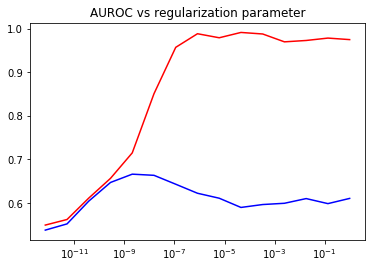

In [14]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train),'r')
plt.plot(np.array(reg), np.array(auc_val), 'b')
plt.xscale('log')
plt.show()

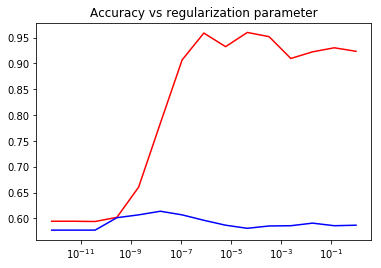

In [15]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train),'r')
plt.plot(np.array(reg), np.array(acc_val), 'b')
plt.xscale('log')
plt.show()

In [16]:
print("Highest accuracy: ", np.max(acc_val))
print("Highest AUROC: ", np.max(auc_val))
print("The optimal regularization value is: ", reg[np.argmax(auc_val)])

Highest accuracy:  0.614
Highest AUROC:  0.6659186966879275
The optimal regularization value is:  2.061153622438558e-09


In [17]:
clf = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val)], multi_class='multinomial').fit(X, Y)
probs = clf.predict_proba(X_val)[:,1]

fpr, tpr, threshold = metrics.roc_curve(Y_val, probs)
roc_auc = metrics.auc(fpr, tpr)

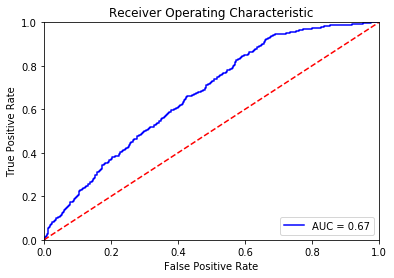

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Scale $96\times96$ features

In [19]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_val_scaled = scaler.transform(X_val)

In [20]:
auc_train_scaled, auc_val_scaled, acc_train_scaled, acc_val_scaled = auroc_and_acc_vs_reg(reg, X_scaled, Y, X_val_scaled, Y_val)

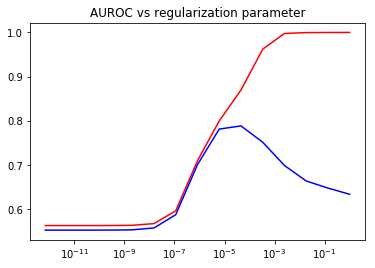

In [21]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_scaled),'r')
plt.plot(np.array(reg), np.array(auc_val_scaled), 'b')
plt.xscale('log')
plt.show()

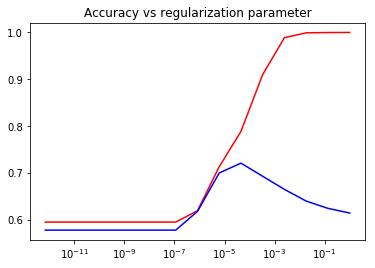

In [22]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_scaled),'r')
plt.plot(np.array(reg), np.array(acc_val_scaled), 'b')
plt.xscale('log')
plt.show()

In [23]:
print("Highest accuracy: ", np.max(acc_val_scaled))
print("Highest AUROC: ", np.max(auc_val_scaled))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_scaled)])

Highest accuracy:  0.7204999999999999
Highest AUROC:  0.7885898716667948
The optimal regularization value is:  4.5399929762484854e-05


### Train on 32x32 images
Start by converting the $96\times96$ images to $32\times32$.

In [24]:
n = 32
X_32 = np.zeros((X.shape[0], n*n*3))
X_val_32 = np.zeros((X_val.shape[0], n*n*3))

In [25]:
for i in range(X.shape[0]):
    X_32[i] = ip.crop_center(X[i,:], (96,96,3), 32)

for j in range(X_val.shape[0]):
    X_val_32[j] = ip.crop_center(X_val[j,:], (96,96,3), 32)

Fit a logistic regression to the center $32\times32$ pixels.

In [26]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_32, Y)

In [27]:
y_pred_train_32 = clf_32.predict(X_32)

In [28]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train_32-Y.T)))

Accuracy on train set:  0.7391666666666667


Predict on the validation set.

In [29]:
y_pred_val_32 = clf_32.predict(X_val_32)

In [30]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val_32-Y_val.T)))

Accuracy on validation set:  0.5954999999999999


Train the model for multiple values of the regularization parameter.

In [31]:
auc_train_32, auc_val_32, acc_train_32, acc_val_32 = auroc_and_acc_vs_reg(reg, X_32, Y, X_val_32, Y_val)

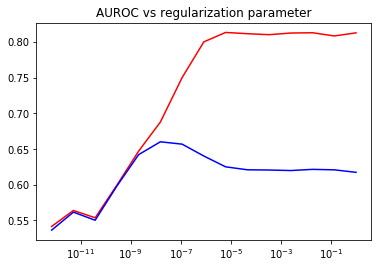

In [32]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_32),'r')
plt.plot(np.array(reg), np.array(auc_val_32), 'b')
plt.xscale('log')
plt.show()

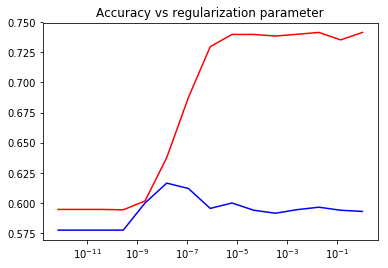

In [33]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_32),'r')
plt.plot(np.array(reg), np.array(acc_val_32), 'b')
plt.xscale('log')
plt.show()

In [34]:
print("Highest accuracy: ", np.max(acc_val_32))
print("Highest AUROC: ", np.max(auc_val_32))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_32)])

Highest accuracy:  0.6165
Highest AUROC:  0.6599902661441124
The optimal regularization value is:  1.522997974471263e-08


In [35]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val_32)], multi_class='multinomial').fit(X_32, Y)
probs_32 = clf_32.predict_proba(X_val_32)[:,1]

fpr_32, tpr_32, threshold_32 = metrics.roc_curve(Y_val, probs_32)
roc_auc_32 = metrics.auc(fpr_32, tpr_32)

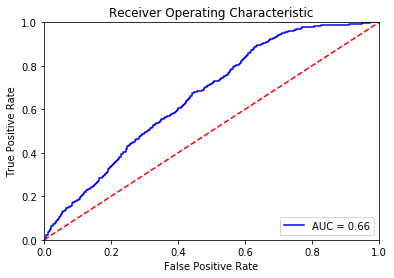

In [36]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_32, tpr_32, 'b', label = 'AUC = %0.2f' % roc_auc_32)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Scale $32\times32$ features

In [37]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_32)
X_32_scaled = scaler.transform(X_32)
X_val_32_scaled = scaler.transform(X_val_32)

In [38]:
auc_train_32_scaled, auc_val_32_scaled, acc_train_32_scaled, acc_val_32_scaled = auroc_and_acc_vs_reg(reg, X_32_scaled, Y, X_val_32_scaled, Y_val)

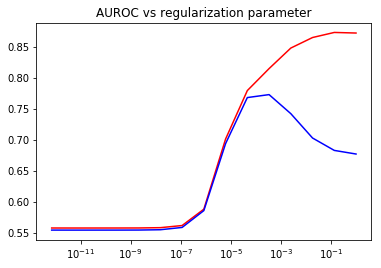

In [39]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_32_scaled),'r')
plt.plot(np.array(reg), np.array(auc_val_32_scaled), 'b')
plt.xscale('log')
plt.show()

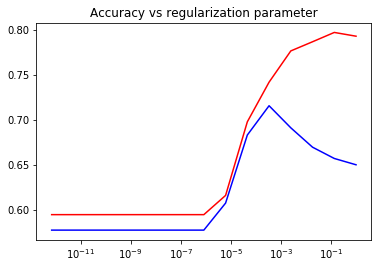

In [40]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_32_scaled),'r')
plt.plot(np.array(reg), np.array(acc_val_32_scaled), 'b')
plt.xscale('log')
plt.show()

In [41]:
print("Highest accuracy: ", np.max(acc_val_32_scaled))
print("Highest AUROC: ", np.max(auc_val_32_scaled))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_32_scaled)])

Highest accuracy:  0.7155
Highest AUROC:  0.7724900740285355
The optimal regularization value is:  0.00033546262790251185


## Error Analysis
A logistic regression model using the full scale images performs better out-of-sample than a model using only the center of the image. However, neither model is close to the leaderboard scores on Kaggle (around 0.95 compared to 0.66-0.67 for our models). Below we perform some error analysis in order to get a better understanding of how we can potentially improve the performance.

First we look at how the performance of the model behaves when we increase the size of the training data:

In [50]:
def cost_vs_train_size(X_in, Y_in, X_val_in, Y_val_in, reg_param, training_sizes):
    # function that calculates the cost for logistic regression using different training sizes
    cost_train_in = []
    cost_val_in = []

    for sz in training_sizes:
        # fit a logistic regression using the 'optimal' regularization
        clf_in = LogisticRegression(solver='lbfgs', tol=1e-4, C=reg_param).fit(X_in[:sz], Y_in[:sz])

        # predict on the training set
        proba_train = clf_in.predict_proba(X_in[:sz,:])[:,1]

        # predict on the validation set
        proba_val = clf_in.predict_proba(X_val_in)[:,1].reshape(-1,1)

        # evaluate the cost on train and validation set
        cost_train_in.append(-1/sz * np.sum(Y_in[:sz] * np.log(proba_train) + (1-Y_in[:sz]) * (np.log(1-proba_train))))
        cost_val_in.append(-1/Y_val_in.shape[0] * np.sum(Y_val_in * np.log(proba_val) + (1-Y_val_in) * (np.log(1-proba_val))))
    
    return cost_train_in, cost_val_in

Comparing cost vs training size for $32\times32$ images where the features have been normalized.

In [51]:
c = reg[np.argmax(auc_val_32)]
n= 60
training_sizes = np.linspace(np.minimum(10,X.shape[0]), X.shape[0], n, endpoint=False).astype(int)
cost_train_32, cost_val_32 = cost_vs_train_size(X_32_scaled, Y, X_val_32_scaled, Y_val, c, training_sizes)

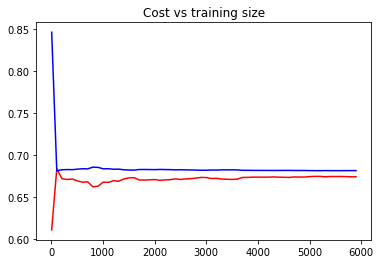

In [52]:
plt.title('Cost vs training size')
plt.plot(training_sizes, np.array(cost_train_32),'r')
plt.plot(training_sizes, np.array(cost_val_32), 'b')
plt.show()

Comparing $96\times96$ images where the features have been scaled.

In [62]:
c = reg[np.argmax(auc_val)]
n=60
training_sizes = np.linspace(np.minimum(10,X.shape[0]), X.shape[0], n, endpoint=False).astype(int)
cost_train, cost_val = cost_vs_train_size(X_scaled, Y, X_val_scaled, Y_val, c, training_sizes)

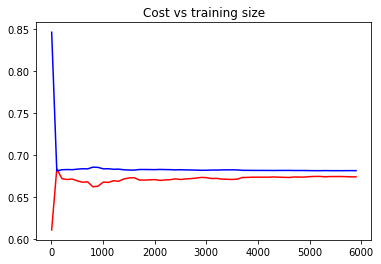

In [63]:
plt.title('Cost vs training size')
plt.plot(training_sizes, np.array(cost_train),'r')
plt.plot(training_sizes, np.array(cost_val), 'b')
plt.show()